2025-01-06 16:52:11.880791: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 16:52:11.883322: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-06 16:52:11.893979: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-06 16:52:11.915003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736171531.949842   47454 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736171531.96

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.6599 - val_loss: 0.4886
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.4756 - val_loss: 0.4856
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.5124 - val_loss: 0.4844
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.4869 - val_loss: 0.4785
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.5070 - val_loss: 0.4739
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.4702 - val_loss: 0.4665
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.4379 - val_loss: 0.4649
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.4822 - val_loss: 0.4509
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.4414 - val_loss: 0.4428
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.4189 - val_loss: 0.4272
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.4467 - val_loss: 0.4169
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0

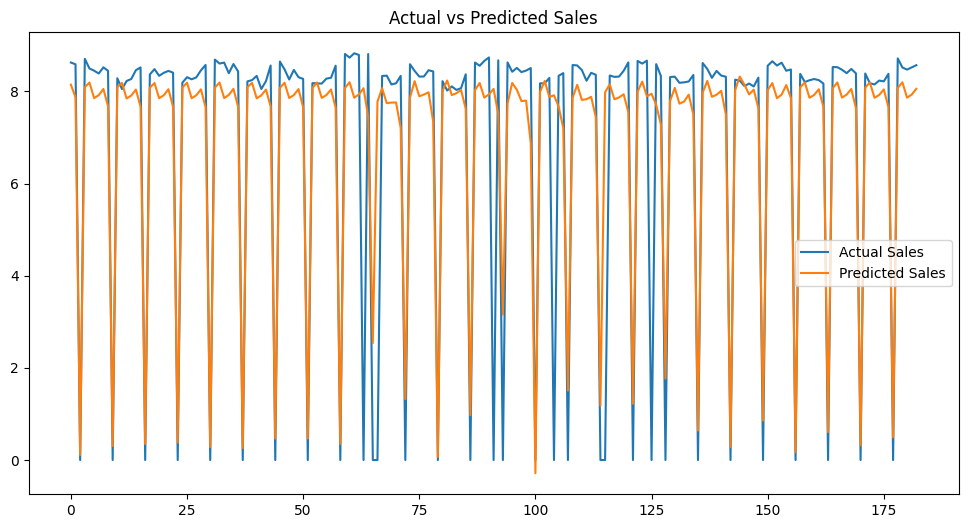

In [1]:
# Rossmann Pharmaceuticals Sales Prediction Notebook

## Task 2: Prediction of Store Sales

### Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import datetime

### Step 2: Load and Merge Datasets
train_df = pd.read_csv('../data/rossmann_store_sales/train.csv')
store_df = pd.read_csv('../data/rossmann_store_sales/store.csv')
merged_df = pd.merge(train_df, store_df, on='Store', how='left')

# Fill missing values
merged_df.fillna({
    'CompetitionDistance': merged_df['CompetitionDistance'].median(),
    'CompetitionOpenSinceMonth': 0,
    'CompetitionOpenSinceYear': 0,
    'Promo2SinceWeek': 0,
    'Promo2SinceYear': 0,
    'PromoInterval': 'None'
}, inplace=True)

# Convert date and extract features
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['Day'] = merged_df['Date'].dt.day
merged_df['DayOfWeek'] = merged_df['Date'].dt.dayofweek
merged_df['WeekOfYear'] = merged_df['Date'].dt.isocalendar().week
merged_df['IsWeekend'] = (merged_df['DayOfWeek'] >= 5).astype(int)

# One-hot encoding
merged_df = pd.get_dummies(merged_df, columns=['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval'], drop_first=True)

# Drop unnecessary columns
merged_df.drop(['Customers', 'Open'], axis=1, inplace=True)

### Step 3: Filter for a Single Store
store_data = merged_df[merged_df['Store'] == 1][['Date', 'Sales']].set_index('Date').sort_index()

# Log transform to stabilize variance
store_data['LogSales'] = np.log1p(store_data['Sales'])

### Step 4: Prepare Data for LSTM
# Supervised learning data
def create_supervised_data(data, lag=1):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag])
        y.append(data[i+lag])
    return np.array(X), np.array(y)

lag = 30  # Use past 30 days to predict next day
sales_values = store_data['LogSales'].values
X, y = create_supervised_data(sales_values, lag)

# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Step 5: Build and Train LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lag, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

### Step 6: Evaluate Model
# Predict
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Sales')
plt.plot(y_pred_inv, label='Predicted Sales')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()
